## Script to split annotated data into cycles and label these

In [7]:
# libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema  # Local minima detection
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path
import os
from utils import compute_relative_keypoints, normalize_signal, smooth_signal, load_json

### Functions needed

In [8]:
# Function to process data from a dataset
def process_data(data, keypoint_indices):
    frames = sorted(set(anno["image_id"] for anno in data.get("annotations", [])))
    
    keypoint_movements = {}
    for joint, index in keypoint_indices.items():
        keypoints_per_joint = {"x": [], "y": []}
        
        for annotation in data.get("annotations", []):
            keypoints = annotation["keypoints"]
            
            # for the choosen reference joint we save the absolute values
            if joint == CHOOSEN_REF:
                absolute_keypoints = []
                for i in range(0, len(keypoints), 3):
                    x, y, v = keypoints[i:i+3]
                    if v == 0:
                        x, y = None, None
                    absolute_keypoints.append((x, y))
                joint_x, joint_y = absolute_keypoints[index]
            # for other joints we save keypoints relative to our reference joints
            else:
                relative_keypoints = compute_relative_keypoints(keypoints, keypoint_indices[CHOOSEN_REF])
                joint_x, joint_y = relative_keypoints[index]

            keypoints_per_joint["x"].append(joint_x)
            keypoints_per_joint["y"].append(joint_y)
            
        keypoint_movements[joint] = keypoints_per_joint

    return frames, keypoint_movements  

# Function to create a dynamic plot for the X values
def create_x_plot(frames, x_values, current_frame):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
    ax.plot(frames[:current_frame + 1], x_values[:current_frame + 1], color='red', label=CHOOSEN_JOINT + ' ' + CHOOSEN_DIM)
    ax.set_xlim([frames[0], frames[-1]])
    ax.set_ylim(min(x_values) - 1, max(x_values) + 1)
    ax.set_xlabel("Frame")
    ax.set_ylabel(CHOOSEN_DIM + " Position")
    ax.legend(loc="upper left")

    canvas = FigureCanvas(fig)
    canvas.draw()
    plot_image = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return plot_image

# Function to save cycles with labels to a JSON file
def save_cycle_to_json(cycle_data, video_id):
    
    filename = "labeled_cycles_"+video_id+".json"
    
    try:
        with open(filename, "r") as file:
            existing_data = json.load(file)
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = {}

    cycle_id = f"Cycle {len(existing_data) + 1}"  # Auto-increment cycle ID
    # TODO what if None?!
    cycle_data[f"{CHOOSEN_JOINT}_{CHOOSEN_DIM}"] = list(map(float, cycle_data[f"{CHOOSEN_JOINT}_{CHOOSEN_DIM}"]))  # Convert NumPy floats to Python floats
    existing_data[cycle_id] = cycle_data

    with open(filename, "w") as file:
        json.dump(existing_data, file, indent=4)
    
    print(f"{cycle_id} saved as {cycle_data['Label']}")


# Function to play video and overlay the X value plot, pausing at local minima
def play_video_with_x_plot(video_path, frames, x_values_raw, x_values_smoothed, min_indices, frame_rate=30):
    
    # x_values_raw = {"LAnkle_x": [], "LAnkle_y": [], ...}

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    current_min_index = 0  # Track local minima

    while current_min_index < len(min_indices) - 1:  # Ensure at least two minima
        start_frame = frames[min_indices[current_min_index]]
        end_frame = frames[min_indices[current_min_index + 1]]
        cycle_values_for_joints = {}
        for joint, values in x_values_raw.items():
            cycle_vals = values[min_indices[current_min_index] : min_indices[current_min_index + 1] + 1]
            cycle_values_for_joints[joint] = cycle_vals

        while True:  # Keep looping until user chooses to proceed
            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
            for current_frame in range(start_frame, end_frame + 1):
                
                ret, frame = cap.read()
                if not ret:
                    print(f"Error: Could not read frame {current_frame}.")
                    break

                plot_image = create_x_plot(frames, x_values_smoothed, current_frame)
                plot_height, plot_width = plot_image.shape[:2]
                frame_height, frame_width = frame.shape[:2]
                plot_resized = cv2.resize(plot_image, (frame_width // 3, plot_height * (frame_width // 3) // plot_width))

                roi = frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:]
                overlayed_frame = cv2.addWeighted(roi, 0.2, plot_resized, 1, 0)
                frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:] = overlayed_frame

                # Show instructions on the frame
                instructions = "Key options | "
                for key, value in LABELS.items():
                    instructions += f"{key} : {value} | "
                instructions += " Replay: r | Quit: q"
                cv2.putText(frame, instructions, (10, frame_height - 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                cv2.imshow("Video with X Plot", frame)
                cv2.waitKey(1000 // frame_rate)

            while True:  # Wait for user input through key press
                key = cv2.waitKey(0) & 0xFF  # Wait indefinitely for a key press

                if chr(key) in LABELS:  # Check if pressed key is in LABELS dictionary
                    cycle_values_for_joints["Label"] = LABELS[chr(key)]
                    cycle_values_for_joints["Start_frame"] = start_frame
                    cycle_values_for_joints["End_frame"] = end_frame
                    current_min_index += 1
                    
                    # check if there are any None values in the lists, if so do not save this cycle
                    isNone = False
                    for value in cycle_values_for_joints.values():
                        if isinstance(value, list) and None in value:
                            isNone = True
                            break
                    if not isNone:
                        save_cycle_to_json(cycle_values_for_joints, video_id)
                    break  # Move to the next cycle

                elif key == ord('r'):  # Replay the same cycle
                    print("Replaying cycle...")
                    break  # Restart the loop to replay

                elif key == ord('q'):  # Quit properly
                    print("Quitting program...")
                    cap.release()
                    cv2.destroyAllWindows()
                    return  # Break out of the inner loop
                
            if chr(key) in LABELS or key == ord('q'):  # Ensure it moves to next interval after labeling
                break  # Exit the entire while loop for this cycle


    cap.release()
    cv2.destroyAllWindows()


### Config

In [9]:
CHOOSEN_JOINT = "RAnkle"
CHOOSEN_REF = "Hip"
CHOOSEN_DIM = "x"
sigma_value = 2  # Adjust smoothing strength
order = 22 # How sensetive to find local minima
#LABELS = ["g2", "g3", "g4", "unknown"]
LABELS = {
    "2" : "gear2",
    "3" : "gear3",
    "4" : "gear4",
    "u" : "unknown"
}
CHOOSEN_KEYPOINTS = [CHOOSEN_JOINT, CHOOSEN_REF,"LShoulder","RShoulder","LElbow","RElbow","LWrist","RWrist","LHip","RHip","LKnee","RKnee","LAnkle","Head","Neck","LBigToe","RBigToe","LSmallToe","RSmallToe","LHeel","RHeel"]

### Paths for videos and annotated data

In [10]:
VIDEO_DIR = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData")
ANNO_DIR = Path(r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\Annotations")
# TODO 25
#video_id = "25" # 09, 14_cut, 15_cut, 17_cut, 18_cut, 22_cut, 25, 38, 40, 43, 44, 54_cut
video_id ="20_cut" # 11, 13, 27, 32, 36, 42, 16_cut, 19_cut, 20_cut, 21_cut, 23_cut, 33, 34, 53 (annotations from finetuned model)
file_path = os.path.join(ANNO_DIR, video_id + ".json")

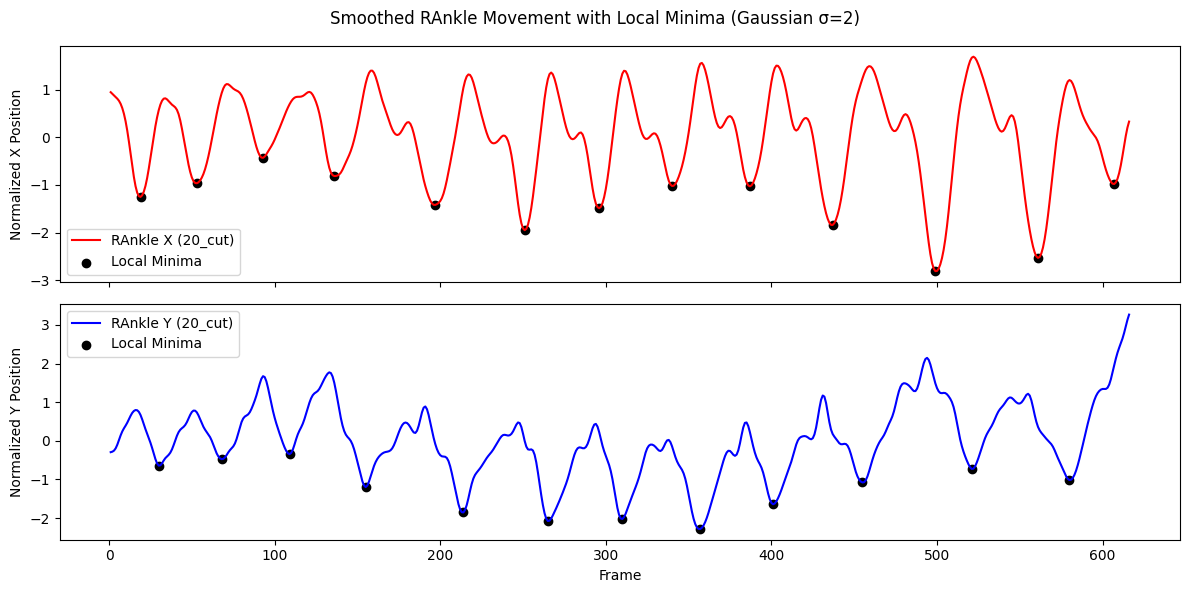

In [11]:
# Load JSON data
dataset = load_json(file_path)

# Extract keypoint labels (assumes same structure across files)
keypoint_labels = dataset["categories"][0]["keypoints"]
#hip_index = keypoint_labels.index("Hip")  # Find the index of the "Hip" keypoint
#lankle_index = keypoint_labels.index(CHOOSEN_JOINT)  # Find index for joint we choose
keypoint_indices = {joint: keypoint_labels.index(joint) for joint in CHOOSEN_KEYPOINTS}

# Process dataset, get keypoints and frames
frames, keypoints = process_data(dataset, keypoint_indices)

# Normalize and smooth all datasets
smoothed_normalized_keypoints = {"x": [], "y": []}
smoothed_normalized_keypoints["x"] = normalize_signal(keypoints[CHOOSEN_JOINT]["x"])
smoothed_normalized_keypoints["y"] = normalize_signal(keypoints[CHOOSEN_JOINT]["y"])

smoothed_normalized_keypoints["x"] = smooth_signal(smoothed_normalized_keypoints["x"], sigma=sigma_value)
smoothed_normalized_keypoints["y"] = smooth_signal(smoothed_normalized_keypoints["y"], sigma=sigma_value)

# Plot Joint movement (X and Y in separate plots)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Detect local minima for X movement
x_values = np.array(smoothed_normalized_keypoints["x"])
x_min_indices = argrelextrema(x_values, np.less, order=order)[0]  

# Detect local minima for Y movement
y_values = np.array(smoothed_normalized_keypoints["y"])
y_min_indices = argrelextrema(y_values, np.less, order=order)[0]  

# Plot choosen joint X movement
axs[0].plot(frames, x_values, label=f"{CHOOSEN_JOINT} X ({file_path[-11:-5]})", color="red")
axs[0].scatter(np.array(frames)[x_min_indices], x_values[x_min_indices], color="black", marker="o", label="Local Minima")
axs[0].set_ylabel("Normalized X Position")
axs[0].legend()

# Plot choosen joint Y movement
axs[1].plot(frames, y_values, label=f"{CHOOSEN_JOINT} Y ({file_path[-11:-5]})", color="blue")
axs[1].scatter(np.array(frames)[y_min_indices], y_values[y_min_indices], color="black", marker="o", label="Local Minima")
axs[1].set_ylabel("Normalized Y Position")
axs[1].set_xlabel("Frame")
axs[1].legend()

plt.suptitle(f"Smoothed {CHOOSEN_JOINT} Movement with Local Minima (Gaussian σ={sigma_value})")
plt.tight_layout()
plt.show()

In [12]:
# Get the corresponding X values for each frame
#keypoints = {"LAnkle" : {"x": [], "y" : []}}
keypoint_values = {}
for joint, values in keypoints.items(): 
    if joint == CHOOSEN_REF:
        key_x, key_y = joint + "_x_ref", joint + "_y_ref"
    else:
        key_x, key_y = joint + "_x", joint + "_y"
    keypoint_values[key_x], keypoint_values[key_y] = values["x"], values["y"]
    
# keypoint_values = {"LAnkle_x": [], "LAnkle_y": [], ...}
    
x_values_smoothed = [smoothed_normalized_keypoints[CHOOSEN_DIM][i] for i in range(len(frames))]

# Video path
video_path = os.path.join(VIDEO_DIR, "DJI_00" + video_id + ".mp4")

if CHOOSEN_DIM == "x":
    min_indices = x_min_indices
else:
    min_indices = y_min_indices
    
# Run the function
play_video_with_x_plot(video_path, frames, keypoint_values, x_values_smoothed, min_indices, frame_rate=30)

Quitting program...
